In [183]:
## imports
import pandas as pd
import os
import plotnine as p9
from plotnine import *
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import requests
import re
import geopandas as gpd
import numpy as np

DROPBOX_YOUR_PATH = "/Users/rebeccajohnson/Dropbox/qss20_finalproj_rawdata/summerwork/"
READ_TRACT_SHAPEFILES = False

## multiple printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## helper func

def getXY(pt):
    return (pt.x, pt.y)


test_read = pd.read_pickle()

## Load datasets

In [107]:
## get tract shapes and write
if READ_TRACT_SHAPEFILES:
    main_url = 'https://www2.census.gov/geo/tiger/TIGER2014/TRACT/'
    raw_content = requests.get(main_url).text
    parsed_content = BeautifulSoup(raw_content, 'html.parser')
    find_links = parsed_content.findAll("a", attrs = {"href": re.compile("tract")})
    zip_names = [link.get('href') for link in find_links]
    zip_links = [main_url + link for link in zip_names]
    list_of_tract_shapes = [gpd.read_file(link) for link in zip_links]
    tract_shapes = pd.concat(list_of_tract_shapes)
    tract_shapes.to_pickle(DROPBOX_YOUR_PATH + "clean/tract_shapefiles.pkl")
else:
    tract_shapes = pd.read_pickle(DROPBOX_YOUR_PATH + "clean/tract_shapefiles.pkl")


In [208]:
## load data with investigations status
## note that despite dtypes, leading zero gets cut off so need to 
## pad if using lower-dig state; doesnt affect this code since using 
## texas where statefp = 48
investigations_data = pd.read_csv(DROPBOX_YOUR_PATH + "clean/whd_violations_wTRLA_catchmentonly.csv",
                                 dtype = {'GEO_ID': 'object'})

## load data that has geocoded census tracts- has point geometry
joborder_pointlocations = pd.read_pickle(DROPBOX_YOUR_PATH + "intermediate/h2a_tract_intersections.pkl")



/Users/rebeccajohnson/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (19,51,156) have mixed types.Specify dtype option on import or set low_memory=False.


In [234]:
## create background of plot shaded by 
texas_tracts = tract_shapes[tract_shapes.STATEFP == "48"].copy()

## string geoid
texas_tracts['GEOID_tomerge'] = texas_tracts.GEOID.astype(str)
investigations_data['GEOID_tomerge'] = investigations_data.GEO_ID.astype(str)

## grab cols we might use
investigations_data_mergecols = [col for col in investigations_data.columns if 
                              "GEOID_tomerge" in col or col.startswith("acs") or
                            "CASE_NUMBER" in col]

## just keep geoid and acs from investigations
focal_dem = 'acs_Male!!45 to 54 years_SEX_BY_AGE__HISPANIC_OR_LATINO_'
acs_tomerge = investigations_data[["GEOID_tomerge"] + [focal_dem]].copy().drop_duplicates().groupby('GEOID_tomerge').\
            agg({focal_dem: np.nanmean}).reset_index()

## tract-level merge and subsetting (doesn't retain sep jobs in same tract)
texas_tracts_wacs = pd.merge(texas_tracts, acs_tomerge,
                            on = "GEOID_tomerge",
                            how = "left")


(5265, 15)

5265

In [200]:
investigations_data.outcome_compare_TRLA_WHD.value_counts()

Neither WHD nor TRLA    25078
TRLA; not WHD            1098
WHD; not TRLA             185
Both TRLA and WHD          32
Name: outcome_compare_TRLA_WHD, dtype: int64

In [233]:
## merge investigation status onto point locations
investigations_wpoint = pd.merge(investigations_data[['EMPLOYER_FULLADDRESS', 'CASE_NUMBER',
                                                     'outcome_compare_TRLA_WHD', 'GEOID_tomerge',
                                                     'jobs_group_id']].copy(),
                                joborder_pointlocations,
                                on = ['EMPLOYER_FULLADDRESS', 'CASE_NUMBER'],
                                how = "left").drop_duplicates()


In [225]:
## subset to ones we cleaned ACS data for

cols_keep = ['GEOID_tomerge', 'geometry'] + [focal_dem]


acs_4p = texas_tracts_wacs.loc[~texas_tracts_wacs[focal_dem].isnull(),
                               cols_keep].copy().drop_duplicates()

acs_4p['tract_centroid'] = acs_4p['geometry'].centroid
acs_4p['tract_lon'], acs_4p['tract_lat'] = [list(t) for t in zip(*map(getXY, acs_4p['tract_centroid']))]
acs_4p.head()

GEOIDs_anyTRLA = investigations_wpoint.GEOID_tomerge[\
            investigations_wpoint.outcome_compare_TRLA_WHD.isin(['TRLA; not WHD', "Both TRLA and WHD"])]
GEOIDs_anyWHD = investigations_wpoint.GEOID_tomerge[\
            investigations_wpoint.outcome_compare_TRLA_WHD.isin(['WHD; not TRLA', "Both TRLA and WHD"])]

GEOIDS_onlyTRLA = set(GEOIDs_anyTRLA).difference(GEOIDs_anyWHD)
GEOIDS_onlyWHD = set(GEOIDs_anyWHD).difference(GEOIDs_anyTRLA)
GEOIDS_neither = investigations_wpoint.GEOID_tomerge[\
            investigations_wpoint.outcome_compare_TRLA_WHD.isin(["Neither WHD nor TRLA"])]

acs_4p['invest_cat'] = np.where(acs_4p.GEOID_tomerge.isin(GEOIDS_onlyTRLA),
                               "TRLA only",
                        np.where(acs_4p.GEOID_tomerge.isin(GEOIDS_onlyWHD),
                                "WHD only",
                        np.where(acs_4p.GEOID_tomerge.isin(GEOIDS_neither),
                                "Neither",
                                "Both")))
acs_4p.invest_cat.value_counts()


SyntaxError: invalid syntax (<ipython-input-225-71bcde58ccc1>, line 4)

In [253]:
os.getcwd()

'/Users/rebeccajohnson/Dropbox/qss20_s21_proj/code'

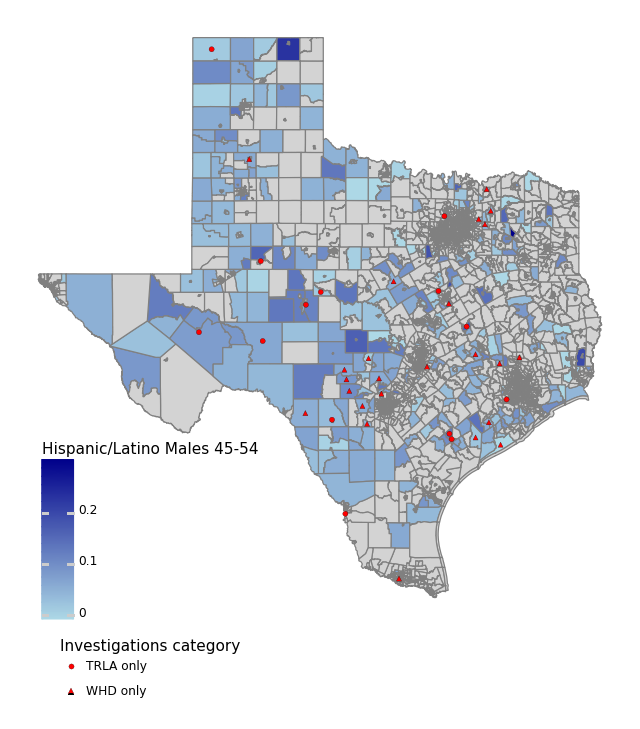

<ggplot: (8762669013538)>

/Users/rebeccajohnson/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 8 x 8 in image.
/Users/rebeccajohnson/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../output/figs/tx_map_investigations.png


In [254]:
## step one: plot shaded background
tx_p = (ggplot() + 
geom_map(texas_tracts_wacs, aes(fill = focal_dem), color = 'gray') +
scale_fill_gradient(low = "#ADD8E6", high = "#00008b",
                   na_value = "#D3D3D3") +
geom_point(acs_4p[acs_4p.invest_cat.str.contains("only")], 
        aes(x = "tract_lon",
        y = "tract_lat", shape = 'invest_cat'), 
           fill = "red",stroke = .1, size = 2) +
theme_classic() +
xlab("") +
ylab("") +
labs(shape = "Investigations category",
      fill = "Hispanic/Latino Males 45-54") +
theme(axis_text_x = element_blank(),
     axis_text_y = element_blank(),
     axis_ticks = element_blank(),
      panel_border = element_blank(),
      legend_background = element_blank(),
      panel_grid=element_blank(),
      axis_line= element_blank(),
      legend_position = (0.3, 0.18),
figure_size = [8, 8]))


tx_p


ggsave(tx_p, filename = "../output/figs/tx_map_investigations.png")

In [ ]:
## discarded code


all_geo_allcat = pd.DataFrame({'GEOID_tomerge': np.repeat(acs_4p.GEOID_tomerge.unique(),
                                            len(investigations_wpoint.outcome_compare_TRLA_WHD.unique())),
                    'outcome_compare_TRLA_WHD': np.repeat(investigations_wpoint.outcome_compare_TRLA_WHD.unique(),
                                            len(acs_4p.GEOID_tomerge.unique()))})


investigations_4p_all = pd.merge(all_geo_allcat,
                                investigations_4p_some,
                                on = ["GEOID_tomerge", 'outcome_compare_TRLA_WHD'],
                                how = "left")
investigations_4p_all['jobs_group_id'].fillna(0, inplace = True)

## next steps:

acs_4p['investigation_cat_tractlevel'] = np.where(acs_4p.GEOID_tomerge.isin(investigations_wpoint.GEOID_tomerge[\
                            investigations_wpoint.outcome_compare_TRLA_WHD.isin(["WHD; not TRLA"])]))


## aggregate to geoid level
investigations_4p_some = investigations_wpoint[investigations_wpoint.GEOID_tomerge.isin(acs_4p.GEOID_tomerge)].\
                            groupby(['GEOID_tomerge', 'outcome_compare_TRLA_WHD']).agg({'jobs_group_id': 'nunique'}).reset_index()

investigations_4p_some.head()
investigations_4p_some_wgeom = pd.merge(investigations_4p_some,
                                       acs_4p[['GEOID_tomerge',
                                               'tract_lat', 'tract_lon']].copy(), on = "GEOID_tomerge")

investigations_trla = investigations_4p_some_wgeom[investigations_4p_some_wgeom.outcome_compare_TRLA_WHD == 
                                                  "TRLA; not WHD"].copy()
investigations_whd = investigations_4p_some_wgeom[investigations_4p_some_wgeom.outcome_compare_TRLA_WHD == 
                                                  "WHD; not TRLA"].copy()